# Machine Learning for Additive Manufacturing

Load in relevant modules


python package dependencies: ```mendeleev, matplotlib, pandas, numpy, pylab, pprint, sklearn, scipy, os```



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from pylab import * # For adjusting frame width only
from meltpoolnet.utils.utils import select_subset
from meltpoolnet.ml.regression_ml import learn
from meltpoolnet.ml.classification_ml import classify_learn
from meltpoolnet.utils.utils import select_parameters, extract_features, select_material
os.getcwd()

'/media/cmu/DATA1/francis/Previous Projects/AdditiveNet/CNN_AM_Project/AdditiveNet'

In [3]:
from sklearn.preprocessing import StandardScaler
from meltpoolnet.utils.plotting_utils import frame_tick
%matplotlib inline

In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Load in data, perform basic analysis

In [5]:
# Load in the csv data, download from Google Sheets and store in directory
print("Current directory: ", os.getcwd())
csv = pd.read_csv('meltpoolgeometry.csv') 
csv1 = pd.read_csv('meltpoolgeometry.csv')
csv2 = pd.read_csv('meltpoolclassification.csv')
regressioncsv =  csv1
class_csv = csv1.append(csv2)
materials = csv['Material'].value_counts()


Current directory:  /media/cmu/DATA1/francis/Previous Projects/AdditiveNet/CNN_AM_Project/AdditiveNet


In [6]:
print('Keys Present in CSV:')
for key in csv.keys():
    print(key)

Keys Present in CSV:
Material
Process
Sub-process
Power
Velocity
Hatch spacing
depth of meltpool
width of melt pool
length of melt pool
d/l
d/w
l/w
E (J/mm)
E (J/mm3)
layer thickness
beam D
absorption coefficient
absorption coefficient 2
density
Cp
k
melting T
minimal absorptivity
meltpool shape
spatter
Y (wt%)
Zn (wt%)
Mg (wt%)
Si (wt%)
Al (wt%)
Sn (wt%)
Zr (wt%)
W (wt%)
Ti (wt%)
V (wt%)
Co (wt%)
Cu (wt%)
Ta (wt%)
Nb (wt%)
Ni  (wt.%)
Cr  (wt.%)
Fe (wt.%)
Mn (wt%)
Mo (wt.%)
D10
D50
D90
paper ID
paper
porosity
relative density
comment
Unnamed: 52


In [37]:
def print_field_composition(csv_input, field):
    print(color.BOLD + field + color.END) 
    column = np.array(csv_input[field], dtype = 'str')
    unique, counts = np.unique(column, return_counts = True)
    indices = np.argsort(counts)[::-1]
    unique_sorted = unique[indices]
    counts_sorted = counts[indices]
    for i in range(len(unique_sorted)):
        print(f'{counts_sorted[i]} entries present in {field} {unique_sorted[i]}')
print_field_composition(csv, 'Material')


Material
639 entries present in Material SS316L
452 entries present in Material Ti-6Al-4V
147 entries present in Material IN718
103 entries present in Material SS17-4PH
97 entries present in Material IN625
50 entries present in Material IN738LC
41 entries present in Material Hastelloy X
35 entries present in Material Cu10Sn
29 entries present in Material AlSi10Mg
25 entries present in Material Al-2.5Fe
24 entries present in Material Al-C-Co-Fe-Mn-Ni
24 entries present in Material Tungsten
20 entries present in Material Ti-49Al-2Cr-2Nb
19 entries present in Material HCP Cu
18 entries present in Material Invar36
16 entries present in Material SS304
12 entries present in Material WE43
12 entries present in Material MS1-
9 entries present in Material CMSX-4
8 entries present in Material TiC/Inconel 718
6 entries present in Material SS304L
6 entries present in Material Ti6242
5 entries present in Material K403 superalloy
4 entries present in Material Ti-45Al
3 entries present in Material 41

In [8]:
# Examine distribution of features
for col in csv.columns:
    values = csv[col]
    num_present = len([value for value in values if not pd.isnull(value)])
    total = len(values)
    parameter = col
    print('{:.1f} % samples have '.format(100*num_present/total) + parameter + ' value')

100.0 % samples have Material value
100.0 % samples have Process value
100.0 % samples have Sub-process value
100.0 % samples have Power value
100.0 % samples have Velocity value
23.7 % samples have Hatch spacing value
80.5 % samples have depth of meltpool value
63.6 % samples have width of melt pool value
17.5 % samples have length of melt pool value
64.2 % samples have d/l value
49.7 % samples have d/w value
35.1 % samples have l/w value
94.0 % samples have E (J/mm) value
20.4 % samples have E (J/mm3) value
79.7 % samples have layer thickness value
81.9 % samples have beam D value
59.5 % samples have absorption coefficient value
63.1 % samples have absorption coefficient 2 value
97.3 % samples have density value
97.3 % samples have Cp value
97.1 % samples have k value
100.0 % samples have melting T value
72.5 % samples have minimal absorptivity value
43.9 % samples have meltpool shape value
0.5 % samples have spatter value
100.0 % samples have Y (wt%) value
100.0 % samples have Zn (w

# Machine Learning

In [9]:
# Example use case
new_csv = select_subset(class_csv, 'Sub-process','SLM')
parameter_list = ['Power', 'Velocity', 'layer thickness']
label_col = 'meltpool shape'
X, y = select_parameters(new_csv, parameter_list, label_col)


## Regression Task

Predicts the melt pool depth based on features of the build process, iterating over the algorithms:


- Random Forests 'RF'


- Gaussian Process Regression 'GPR'


- Support Vector Regression 'SVR'


- Ridge Linear Regression 'Ridge'


- Lasso Linear Regression  'Lasso'


- Gradient Boosted Random Forest 'GB'



- Neural Network 'NN'

Base ML case considers process and thermodynamic parameters, and later cells add one-hot-encoding and elemental features


In [151]:
def draw_regression_process_map(csv_subset, label_column, title = '', dpi  = 300, model_name  = 'RF'):
    
    parameter_list = ['Velocity', 'Power']
    
    data_list = []
    label_list = []
    for i in range(len(csv_subset)):
        success, features, label = extract_features(csv_subset.iloc[i], parameter_list, label_column)

        if success < 0:
            continue
        else:
            data_list.append(features)
            label_list.append(label)
    X = np.array(np.squeeze(data_list))
    print(X.shape)
    y = np.array(label_list)
    
    print(f'Using: {model_name}')
    fit_models, train_accuracy, train_accuracy_std, test_accuracy, test_accuracy_std  = learn(X.reshape(-1, len(parameter_list)), y, parameters = parameter_list, title = 'SLM', model_name = model_name)
        
    scaler = StandardScaler()
    scaler.fit(X)
    X_rescale = scaler.transform(X)
    mean = np.mean(y)
    std = np.std(y)
    ynorm = (y - mean)/std
    nx = 300
    ny = 300

    xs = np.linspace(1.1*np.min(X_rescale[:,0]), 1.1*np.max(X_rescale[:,0]), nx)
    ys = np.linspace(1.1*np.min(X_rescale[:,1]), 1.1*np.max(X_rescale[:,1]), ny)

    xx, yy = np.meshgrid(xs, ys)
    for idx,model in enumerate(fit_models):
        print(dpi)
        fig = plt.figure(figsize = [4,3], dpi = dpi)
    
        xx, yy = np.meshgrid(xs, ys)
        W = model.predict(np.c_[xx.ravel(), yy.ravel()])
        
        xx_unscaled = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
        xx = xx_unscaled[:,0].reshape(xx.shape)
        yy = xx_unscaled[:, 1].reshape(yy.shape)

        #Z = np.argmax(W, axis = 1)
        Z = W
        
        Z = Z.reshape(xx.shape)
        ax = plt.subplot(111)
        plt.pcolormesh(xx, yy, (Z*std+mean), cmap = 'jet')

        
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('Melt Pool Depth', rotation = 270, labelpad = 10)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        plt.title(model_name + ' ' + title)
        
        plt.xticks(fontsize = 8)
        plt.yticks(fontsize = 8)
        frame_tick()
        plt.ylabel(r'Power [W]')
        plt.xlabel(r'Velocity ([mm/s])')
        plt.tight_layout()
        plt.scatter(X[:,0], X[:, 1], c = y, edgecolor = 'k', cmap = 'jet')
        plt.tight_layout()
        plt.show()

Example 1: Regression Map based on all Ti-6Al-4V L-PBF data points found in the dataset

paper ID
70 entries present in paper ID 34
56 entries present in paper ID Runbo data
49 entries present in paper ID 15
29 entries present in paper ID 47
20 entries present in paper ID 70
17 entries present in paper ID 17
16 entries present in paper ID 2
12 entries present in paper ID 1
11 entries present in paper ID 76
9 entries present in paper ID 50
8 entries present in paper ID 79
7 entries present in paper ID 45
(296, 2)
Using: NN
NN  Train R^2: 0.92005 ± 0.01699, Test R^2: 0.61621 ± 0.16867
300


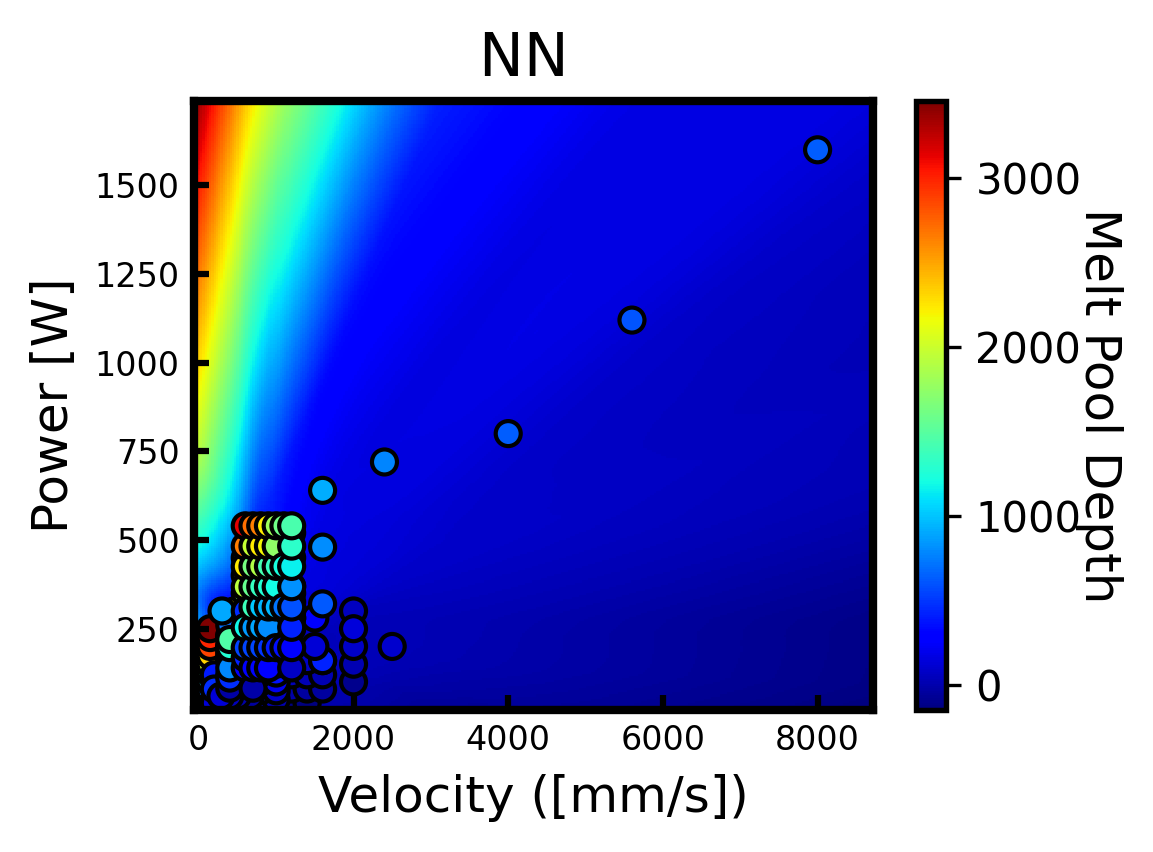

In [152]:

# Define parameters that models will be trained on and value to be predicted
parameter_list = ['Velocity', 'Power']
label_col = 'meltpool shape'

new_csv = select_material(regressioncsv, 'Ti-6Al-4V')
new_csv = select_subset(new_csv, 'Sub-process','SLM')
print_field_composition(new_csv, 'paper ID')

draw_regression_process_map(new_csv, dpi = 300, model_name = 'NN', label_column = 'depth of meltpool')


Example 2: Regression Map based only on Ti-6Al-4V L-PBF data points found within a specific paper

paper ID
70 entries present in paper ID 34
64 entries present in paper ID 13
61 entries present in paper ID 49
56 entries present in paper ID Runbo data
49 entries present in paper ID 15
29 entries present in paper ID 47
20 entries present in paper ID 70
17 entries present in paper ID 17
16 entries present in paper ID 2
12 entries present in paper ID 48
12 entries present in paper ID 1
11 entries present in paper ID 76
9 entries present in paper ID 50
8 entries present in paper ID 79
8 entries present in paper ID 42
7 entries present in paper ID 45
3 entries present in paper ID 54
(64, 2)
Using: NN
NN  Train R^2: 0.91145 ± 0.01282, Test R^2: 0.73003 ± 0.14885
300


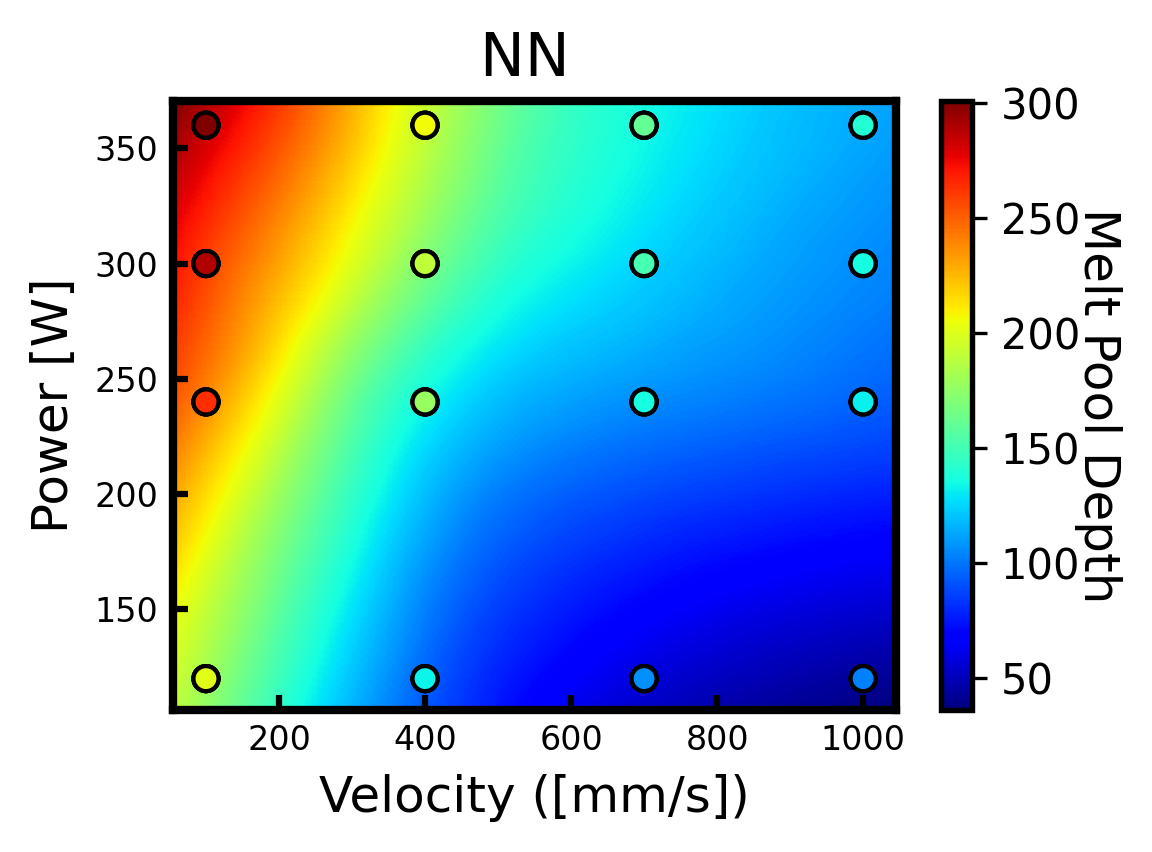

In [153]:
# Define parameters that models will be trained on and value to be predicted
parameter_list = ['Velocity', 'Power']
label_col = 'meltpool shape'

new_csv = select_material(regressioncsv, 'Ti-6Al-4V')
print_field_composition(new_csv, 'paper ID')
# Selecting paper 34
new_csv = select_subset(new_csv, 'paper ID', '13')
draw_regression_process_map(new_csv, dpi = 300, model_name = 'NN', label_column = 'depth of meltpool')

## Classification task 

Predicts the melt pool shape based on features of the build process. The potential classes are `spatter`, `balling`, `keyhole`, `desirable`, and `LOF`  describing either the type of defect, or indicating that there is  no defect in the `desirable` case. The following algorithms are used to generate predictions, and their accuracies are compared.


- Random Forests 'RF'


- Gaussian Process Classification 'GPC'


- Support Vector Classification 'SVC'


- Logistic Regression 'Logistic Regression'


- Gradient Boosted Random Forest 'GB'



- Neural Network 'NN'

The base ML case considers process and thermodynamic parameters, and later cells add one-hot-encoding and elemental features


## Classification Decision Boundaries based on Power and Velocity

In [138]:
def draw_classification_process_map(csv_subset, label_column, dpi  = 300, model_name  = 'RF', title = ''):
    
    parameter_list = ['Velocity', 'Power']
    data_list = []
    label_list = []
    if len(csv_subset) == 0:
        print('No data found for this subset')
        return
    for i in range(len(csv_subset)):
        success, features, label = extract_features(csv_subset.iloc[i], parameter_list, label_col)
        if success < 0 or not label in ['keyhole', 'LOF', 'desirable'] :
            continue
        else:
            data_list.append(features)
            label_list.append(label)


    X= np.array(np.squeeze(data_list))
    y = np.array(label_list)
    labels = np.unique(y)
    label_id = np.arange(len(labels))

    class_labels = np.zeros(len(y))
    for idx, sample in enumerate(y):
        for l_id, lbl in enumerate(labels):
            if lbl == sample:
                class_labels[idx] = l_id

                
   
    class_labels = np.array(class_labels,dtype = 'int')


    fit_models, train_accuracy, train_accuracy_std, test_accuracy, test_accuracy_std = classify_learn(X.reshape(-1, len(X[0])), 
                                                                                                    class_labels,
                                                                                                    label_names = label_id, 
                                                                                                    prefix= 'decbound', 
                                                                                                    parameters = parameter_list, 
                                                                                                    title = 'SLM', 
                                                                                                    plot = False, 
                                                                                                    model_name = model_name)
    # fit_models will be a list with one trained model
    model = fit_models[0]
    scaler = StandardScaler()
    scaler.fit(X)
    X_rescale = scaler.transform(X)

    nx = 300
    ny = 300

    xs = np.linspace(1.1*np.min(X_rescale[:,0]), 1.1*np.max(X_rescale[:,0]), nx)

    ys = np.linspace(1.1*np.min(X_rescale[:,1]), 1.1*np.max(X_rescale[:,1]), ny)

    xx, yy = np.meshgrid(xs, ys)
        


    fig = plt.figure(figsize = [4,3], dpi = dpi)

    xx, yy = np.meshgrid(xs, ys)
    W = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    xx_unscaled = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    xx = xx_unscaled[:,0].reshape(xx.shape)
    yy = xx_unscaled[:, 1].reshape(yy.shape)

    Z = W
    Z = Z.reshape(xx.shape)

    ax = plt.subplot(111)
    cmap = plt.get_cmap('viridis', len(np.unique(class_labels)))

    plt.pcolormesh(xx, yy, (Z), cmap = cmap)
    cbar = plt.colorbar()
    plt.clim(np.min(np.unique(class_labels)) - 0.5, np.max(np.unique(class_labels)) +0.5)
    strings= labels
    cbar.set_ticks(np.arange(len(np.unique(class_labels))))
    cbar.set_ticklabels(strings)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.title(f'{model_name}' + f', {title}' + ', LPBF')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    frame_tick()
    plt.xlabel(r'Velocity (mm/s)')
    plt.ylabel(r'Power')
    plt.tight_layout()

    plt.scatter(X[:,0], X[:, 1], c = class_labels, edgecolor = 'k', cmap= cmap)
    plt.tight_layout()
    plt.show()
    plt.clf()

### Classification Decision Boundary

Predicts the melt pool shape based on laser power and velocity. The potential classes are `keyhole`, `desirable`, and `LOF` --  describing either the type of defect, or indicating that there is  no defect in the `desirable` case. The following algorithms can be used to generate predictions by specifying the model_name parameter.

- Random Forests `RF`


- Gaussian Process Classification `GPC`


- Support Vector Classification `SVC`


- Logistic Regression `Logistic Regression`


- Gradient Boosted Random Forest `GB`



- Neural Network `NN`


Example 1: Decision Boundary based on all Ti-6Al-4V L-PBF papers in the dataset

NN Train Accuracy: 0.96204 ± 0.01569, Test Accuracy: 0.64332 ± 0.08914


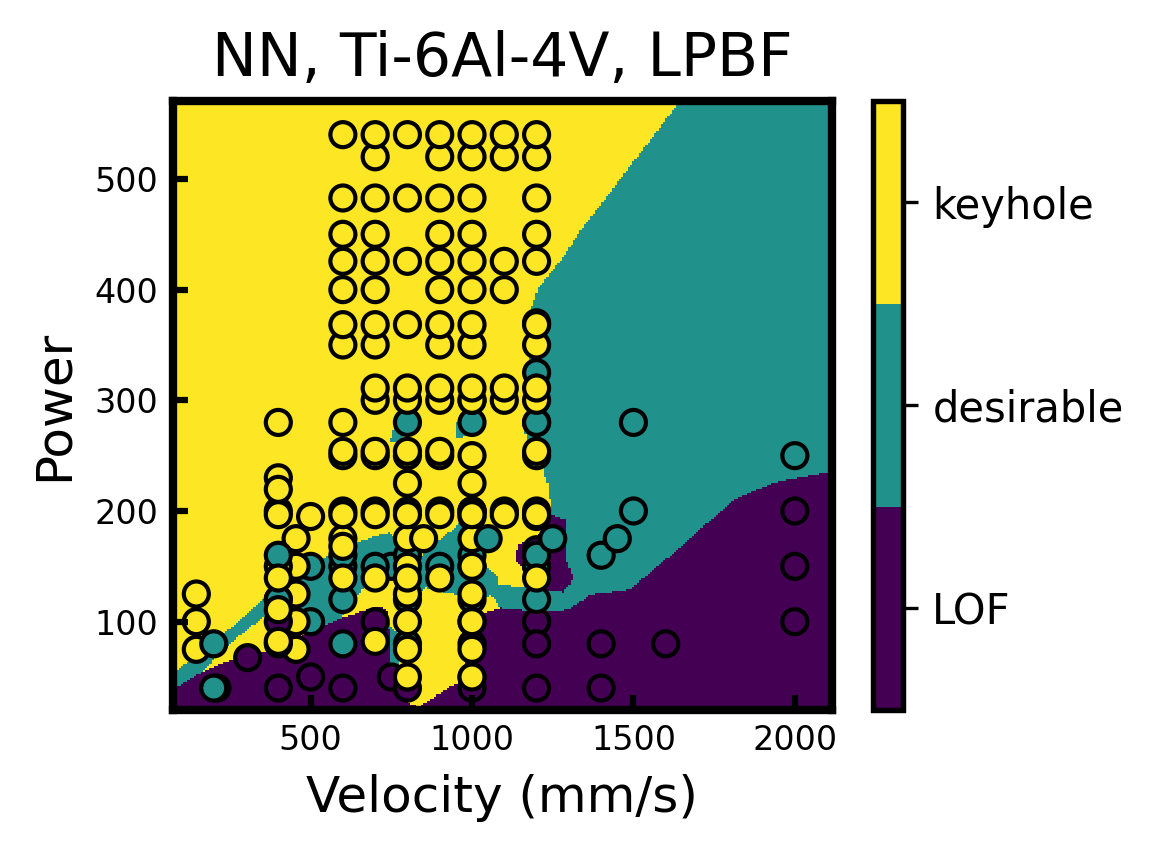

<Figure size 432x288 with 0 Axes>

In [137]:
# Define parameters that models will be trained on and value to be predicted
parameter_list = ['Velocity', 'Power']#['Power', 'Velocity', 'Hatch spacing', 'width of melt pool']
label_col = 'meltpool shape'
#Form dataset array from dataframe, given parameter_list, label_col
# function select_parameters() does this as well
data_list = []
label_list = []
new_csv = select_subset(class_csv, 'Sub-process', 'SLM')
new_csv = select_material(new_csv, 'Ti-6Al-4V')

draw_classification_process_map(new_csv, dpi = 300, model_name = 'NN', label_column = 'meltpool shape')

Example 2: Decision Boundary based only on SS316L L-PBF data points found within a specific paper

Material
100 entries present in Material SS316L
paper ID
72 entries present in paper ID 69
28 entries present in paper ID 49
NN Train Accuracy: 1.00000 ± 0.00000, Test Accuracy: 0.74000 ± 0.29695


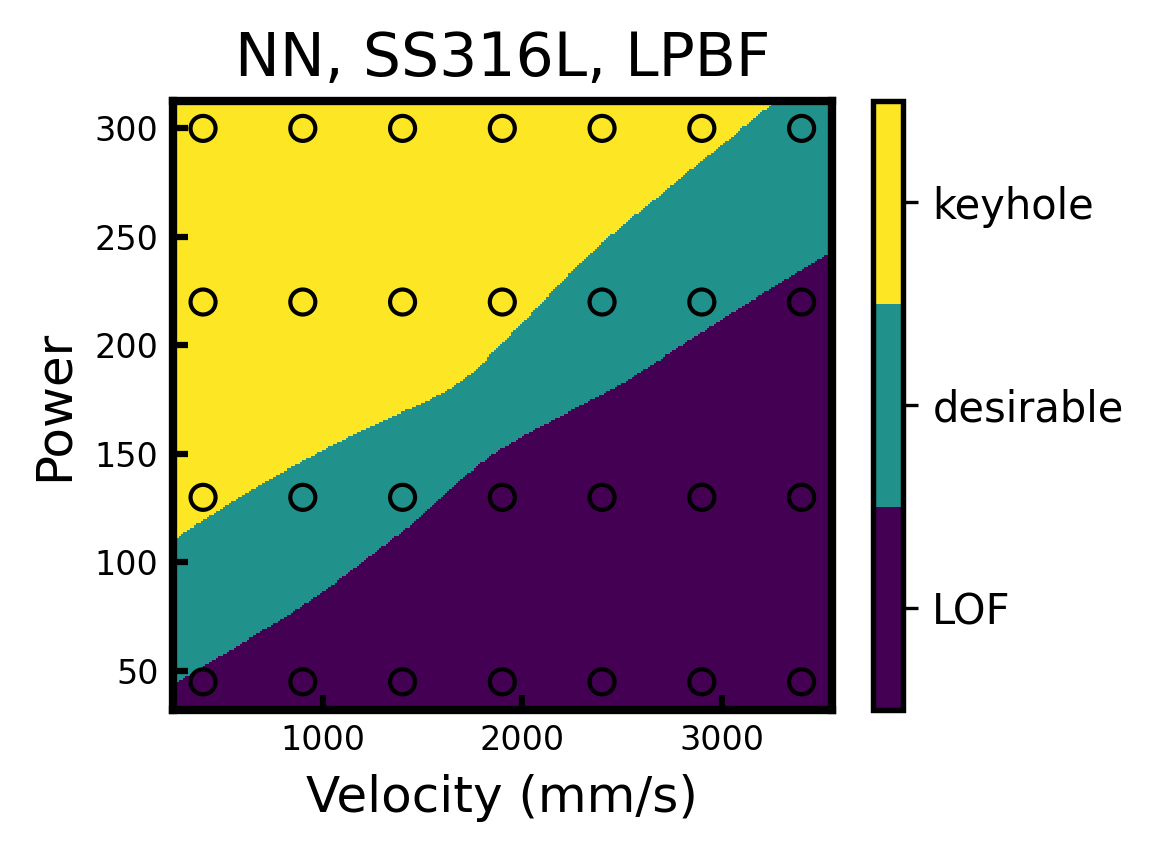

<Figure size 432x288 with 0 Axes>

In [140]:
# Define parameters that models will be trained on and value to be predicted
parameter_list = ['Velocity', 'Power']
label_col = 'meltpool shape'

new_csv = select_material(csv2, 'SS316L')
print_field_composition(new_csv, 'Material')
print_field_composition(new_csv, 'paper ID')

# Selecting paper 34
new_csv = select_subset(new_csv, 'paper ID', 49)
draw_classification_process_map(new_csv, dpi = 300, model_name = 'NN', title = 'SS316L', label_column = 'meltpool shape')